# Should we remove the slowest nodes?

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    dgemm_model = get_yaml(name, dgemm_file[0])
    synthetic = 'experiment_date' not in dgemm_model['info']
    result['synthetic'] = synthetic
    try:
        nb_removed_nodes = dgemm_model['info']['nb_removed_nodes']
    except KeyError:
        nb_removed_nodes = 0
    result['nb_removed_nodes'] = nb_removed_nodes
    sum_gflops = sum(2e-9/node['mnk'] for node in dgemm_model['model'])
    min_gflops = min(2e-9/node['mnk'] for node in dgemm_model['model'])
    result['theoretical_peak'] = sum_gflops
    result['theoretical_smart_peak'] = min_gflops*dgemm_model['info']['nb_nodes']
    return result

simulation_dir = 'synthetic_model/2/'
simulation_files = [os.path.join(simulation_dir, f) for f in os.listdir(simulation_dir) if f.endswith('.zip')]

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,minor_page_fault,cpu_utilization,platform,filename,synthetic,nb_removed_nodes,theoretical_peak,theoretical_smart_peak,nb_nodes,geometry
0,300000,512,13,19,1,2,2,1,0,8,...,380915858,0.99,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,208426.162269,198315.753284,247,13×19
1,500000,512,13,19,1,2,2,1,0,8,...,1177095857,0.99,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,208426.162269,198315.753284,247,13×19
2,100000,512,13,19,1,2,2,1,0,8,...,24926163,1.01,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,208426.162269,198315.753284,247,13×19
3,200000,512,13,19,1,2,2,1,0,8,...,135071761,1.00,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,208426.162269,198315.753284,247,13×19
4,400000,512,13,19,1,2,2,1,0,8,...,726877786,0.99,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,208426.162269,198315.753284,247,13×19


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp',
                  'theoretical_peak', 'theoretical_smart_peak'}
colnames = set(df) - name_exceptions

In [3]:
df.groupby(list(colnames))[['swap']].count()

swap
thread_per_process geometry process_per_node bcast nb_nodes depth synthetic nb_removed_nodes pfact rfact proc_q proc_p mem_align swap block_size      
32                 10×24    1                2     240      1     True      16               1     2     24     10     8         0    512           50
                   10×25    1                2     250      1     True      6                1     2     25     10     8         0    512           50
                   11×22    1                2     242      1     True      14               1     2     22     11     8         0    512           50
                   11×23    1                2     253      1     True      3                1     2     23     11     8         0    512           50
                   12×20    1                2     240      1     True      16               1     2     20     12     8         0    512           50
                   12×21    1                2     252      1     True      4                1     2     21     12     8         0    512           50
                   13×19    1                2     247      1     True      9                1     2     19     13     8         0    512           50
                   14×18    1                2     252      1     True      4                1     2     18     14     8         0    512           50
                   15×16    1                2     240      1     True      16               1     2     16     15     8         0    512           50
                   15×17    1                2     255      1     True      1                1     2     17     15     8         0    512           50
                   16×15    1                2     240      1     True      16               1     2     15     16     8         0    512           50
                   16×16    1                2     256      1     True      0                1     2     16     16     8         0    512           50
                   17×15    1                2     255      1     True      1                1     2     15     17     8         0    512           50
                   18×14    1                2     252      1     True      4                1     2     14     18     8         0    512           50
                   19×13    1                2     247      1     True      9                1     2     13     19     8         0    512           50
                   1×256    1                2     256      1     True      0                1     2     256    1      8         0    512           50
                   20×12    1                2     240      1     True      16               1     2     12     20     8         0    512           50
                   21×12    1                2     252      1     True      4                1     2     12     21     8         0    512           50
                   22×11    1                2     242      1     True      14               1     2     11     22     8         0    512           50
                   23×11    1                2     253      1     True      3                1     2     11     23     8         0    512           50
                   24×10    1                2     240      1     True      16               1     2     10     24     8         0    512           50
                   25×10    1                2     250      1     True      6                1     2     10     25     8         0    512           50
                   27×9     1                2     243      1     True      13               1     2     9      27     8         0    512           50
                   2×128    1                2     256      1     True      0                1     2     128    2      8         0    512           50
                   31×8     1                2     248      1     True      8                1     2     8      31     8         0    512           50
                   32×8     1                2     256      1     Tru

In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu_synthetic.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-255" speed="1" bw="12.5GBps" lat="0.05us"/>
    </AS>
</platform>

```

### Checking the patch in the simulation

In [5]:
patches = set()
for row in df.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

## Impact on the predicted HPL performance

In [6]:
from numpy import log
df['squareness'] = log(df['proc_p'] / df['proc_q'])

In [7]:
df['n3'] = df.matrix_size ** 3
df['n2'] = df.matrix_size ** 2
df['n'] = df.matrix_size

In [8]:
from statsmodels.formula.api import ols
reg = {}
for geom in df['geometry'].unique():
    reg[geom] = ols('time ~ n3 + n2 + n', df[df['geometry'] == geom]).fit()

In [9]:
all_pred = []
for geom, r in reg.items():
    pars = r.params
    pred = pandas.DataFrame([{'n': n*10000} for n in range(1, 100)])
    pred['n2'] = pred['n']**2
    pred['n3'] = pred['n']**3
    pred['matrix_size'] = pred['n']
    pred['time'] = pars['Intercept']
    for col in ['n', 'n2', 'n3']:
        pred['time'] += pred[col]*pars[col]
    pred['gflops'] = (2/3*pred['n3'] + 2*pred['n2']) / pred['time'] * 1e-9
    pred['geometry'] = geom
    all_pred.append(pred)
pred = pandas.concat(all_pred)
pred = pred.set_index('geometry').join(df[['geometry', 'nb_nodes', 'squareness']].set_index('geometry')).reset_index()  # setting the number of nodes

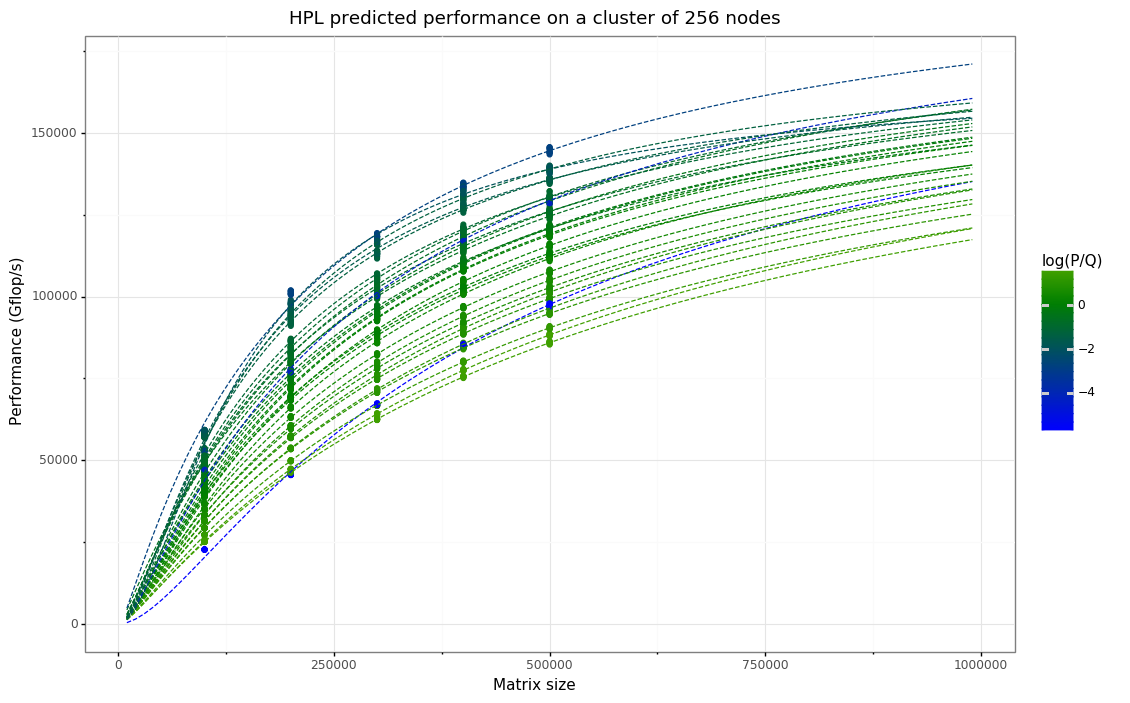

<ggplot: (8752623061284)>

In [10]:
ggplot(df) +\
    aes(x='matrix_size', group='geometry', color='squareness') +\
    geom_point(aes(y='gflops')) +\
    geom_line(pred, aes(y='gflops'), linetype='dashed') +\
    xlab('Matrix size') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='log(P/Q)') +\
    expand_limits(y=0) +\
    ggtitle('HPL predicted performance on a cluster of 256 nodes') +\
    theme_bw() +\
    scale_color_gradient2(low = 'blue', mid = 'green', high = 'yellow', midpoint=0)

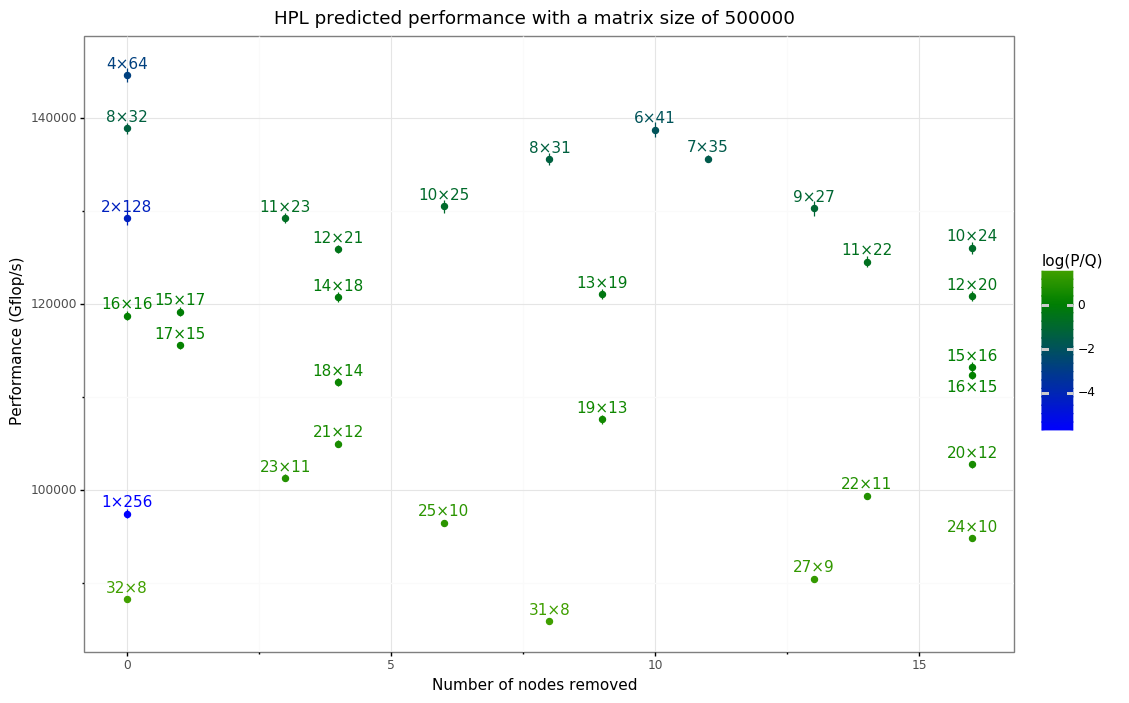

<ggplot: (8752622849270)>

In [11]:
from numpy import mean, std

tmp = df[df['matrix_size'] == df['matrix_size'].max()]
txt = tmp.groupby(['geometry', 'nb_nodes', 'nb_removed_nodes', 'squareness', 'proc_p', 'proc_q'])[['gflops']].mean().reset_index()
txt['txt'] = txt['geometry'] # + '=' + txt['nb_nodes'].astype(str)
txt.loc[txt.geometry == '16×15', 'gflops'] -= 2500
ggplot(tmp) +\
    aes(x='nb_removed_nodes', y='gflops', color='squareness', group='geometry') +\
    theme_bw() +\
    stat_summary(fun_ymin=lambda l: mean(l)-std(l), fun_ymax=lambda l: mean(l)+std(l), fun_y=mean) +\
    xlab('Number of nodes removed') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='log(P/Q)') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(txt, aes(label='txt'), position=position_nudge(y=1200)) +\
    scale_color_gradient2(low = 'blue', mid = 'green', high = 'yellow', midpoint=0)

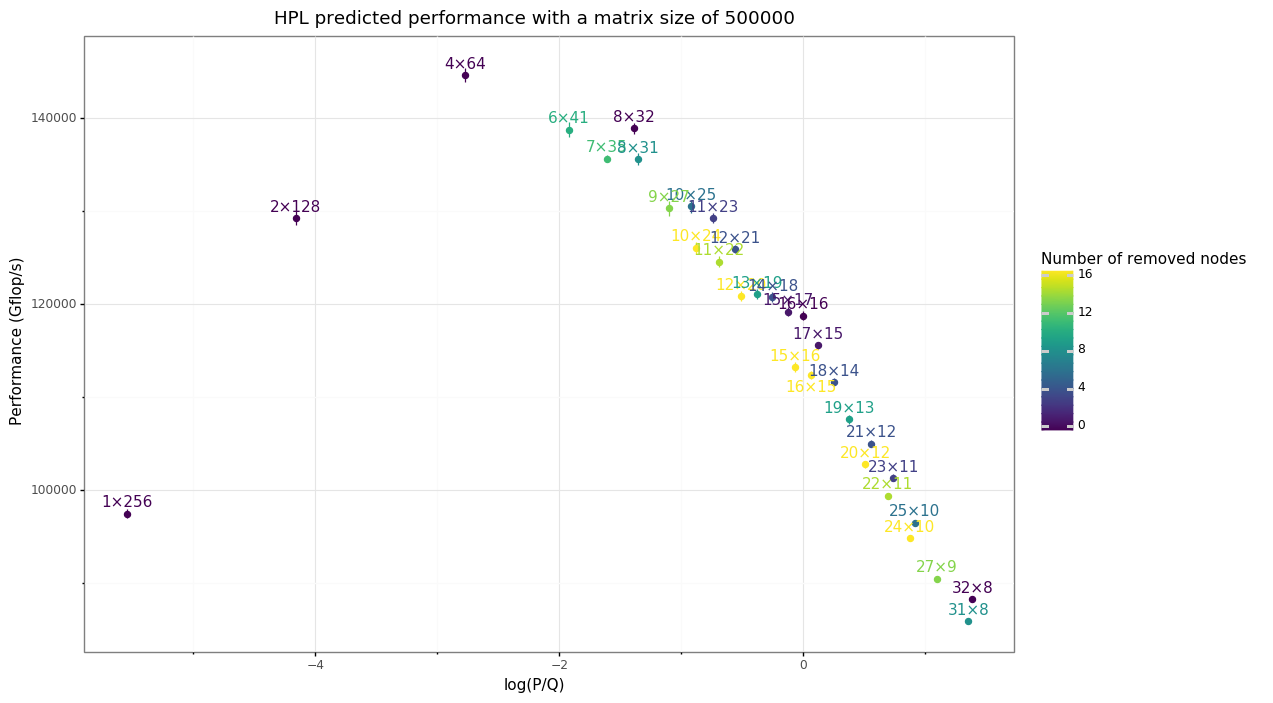

<ggplot: (8752615917993)>

In [12]:
ggplot(tmp) +\
    aes(x='squareness', y='gflops', color='nb_removed_nodes', group='geometry') +\
    theme_bw() +\
    stat_summary(fun_ymin=lambda l: mean(l)-std(l), fun_ymax=lambda l: mean(l)+std(l), fun_y=mean) +\
    xlab('log(P/Q)') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='Number of removed nodes') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(txt, aes(label='txt'), position=position_nudge(y=1200))

## Simulation time

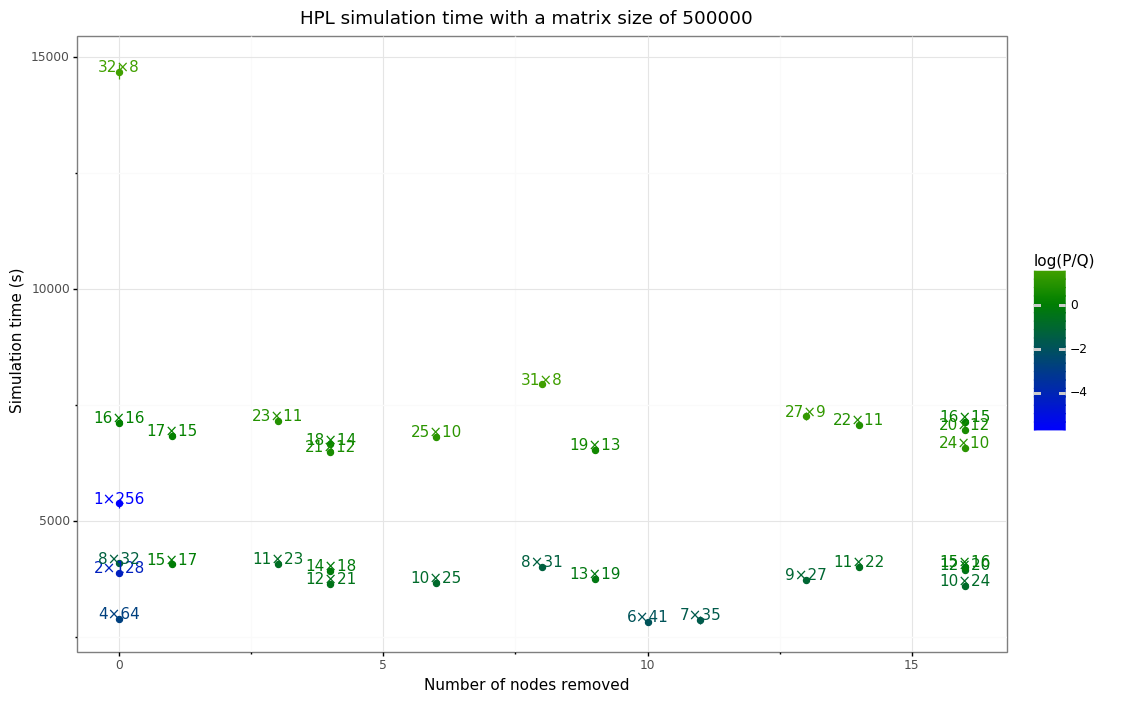

<ggplot: (8752615208312)>

In [13]:
from numpy import mean, std

tmp = df[df['matrix_size'] == df['matrix_size'].max()]
txt = tmp.groupby(['geometry', 'nb_nodes', 'nb_removed_nodes', 'squareness'])[['simulation_time']].mean().reset_index()
txt['txt'] = txt['geometry'] # + '=' + txt['nb_nodes'].astype(str)
#txt.loc[txt.geometry == '16×15', 'simulation_time'] -= 2500
ggplot(tmp) +\
    aes(x='nb_removed_nodes', y='simulation_time', color='squareness', group='geometry') +\
    theme_bw() +\
    stat_summary(fun_ymin=lambda l: mean(l)-std(l), fun_ymax=lambda l: mean(l)+std(l), fun_y=mean) +\
    xlab('Number of nodes removed') +\
    ylab('Simulation time (s)') +\
    labs(color='log(P/Q)') +\
    ggtitle(f'HPL simulation time with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(txt, aes(label='txt'), position=position_nudge(y=100)) +\
    scale_color_gradient2(low = 'blue', mid = 'green', high = 'yellow', midpoint=0)

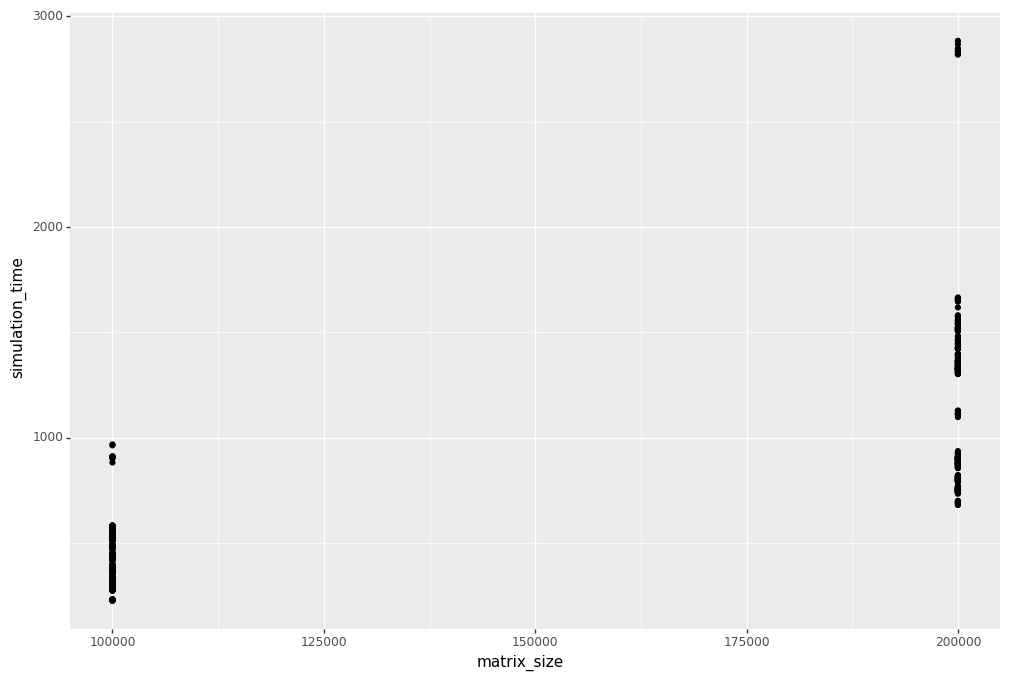

<ggplot: (8752607565474)>

In [183]:
ggplot(df[df.matrix_size <= 200000]) + aes(x='matrix_size', y='simulation_time') + geom_point()

## Predicting the performance with P and Q

In [132]:
df['log_p'] = log(df['proc_p'])
df['log_q'] = log(df['proc_q'])
reg = ols('time ~ n3 + n2 + n + log_p + log_q', df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:                    time   R-squared:                       0.950
Model:                             OLS   Adj. R-squared:                  0.950
Method:                  Least Squares   F-statistic:                 1.510e+04
Date:              mar., 07 avril 2020   Prob (F-statistic):               0.00
Time:                         15:55:30   Log-Likelihood:                -8784.9
No. Observations:                 1595   AIC:                         1.758e+04
Df Residuals:                     1592   BIC:                         1.759e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.722e-10   6.12e-10      0.608      0.543   -8.29e-10    1.57e-09
n3          3.534e-15   3.84e-16      9.199      0.000    2.78e-15    4.29e-15
n2          1.103e-09   2.79e-10      3.953      0.000    5.56e-10    1.65e-09
n           2.921e-05    4.8e-05      0.608      0.543    -6.5e-05       0.000
log_p       9.321e-10   1.53e-09      0.608      0.543   -2.08e-09    3.94e-09
log_q        1.12e-09   1.84e-09      0.608      0.543   -2.49e-09    4.74e-09
==============================================================================
Omnibus:                      260.550   Durbin-Watson:                   1.328
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              649.472
Skew:                           0.890   Prob(JB):                    9.31e-142
Kurtosis:                       5.570   Cond. No.                     1.61e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+19. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [133]:
tmp = df[df['matrix_size'] == df['matrix_size'].max()].copy()
reg = ols('time ~ log_p + log_q + proc_p + proc_q + nb_nodes', tmp).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:                    time   R-squared:                       0.998
Model:                             OLS   Adj. R-squared:                  0.998
Method:                  Least Squares   F-statistic:                 3.018e+04
Date:              mar., 07 avril 2020   Prob (F-statistic):               0.00
Time:                         15:55:32   Log-Likelihood:                -955.12
No. Observations:                  319   AIC:                             1922.
Df Residuals:                      313   BIC:                             1945.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.754e+04   6246.851     -4.409      0.000   -3.98e+04   -1.52e+04
log_p       6372.3734   1384.538      4.603      0.000    3648.195    9096.552
log_q       6344.7236   1384.525      4.583      0.000    3620.571    9068.876
proc_p        15.3386      0.163     94.304      0.000      15.019      15.659
proc_q         1.9034      0.025     76.720      0.000       1.855       1.952
nb_nodes     -28.4766      5.590     -5.094      0.000     -39.476     -17.477
==============================================================================
Omnibus:                        2.353   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                2.335
Skew:                          -0.208   Prob(JB):                        0.311
Kurtosis:                       2.946   Cond. No.                     6.02e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [139]:
reg = ols('time ~ log_p + log_q + proc_p + proc_q', tmp).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:                    time   R-squared:                       0.998
Model:                             OLS   Adj. R-squared:                  0.998
Method:                  Least Squares   F-statistic:                 3.494e+04
Date:              mar., 07 avril 2020   Prob (F-statistic):               0.00
Time:                         16:26:32   Log-Likelihood:                -967.82
No. Observations:                  319   AIC:                             1946.
Df Residuals:                      314   BIC:                             1964.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4278.5063     71.668     59.699      0.000    4137.496    4419.517
log_p       -679.9629     13.575    -50.088      0.000    -706.673    -653.253
log_q       -707.5780     12.819    -55.196      0.000    -732.801    -682.356
proc_p        15.3311      0.169     90.727      0.000      14.999      15.664
proc_q         1.8922      0.026     73.697      0.000       1.842       1.943
==============================================================================
Omnibus:                       10.168   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.338
Skew:                          -0.392   Prob(JB):                      0.00569
Kurtosis:                       3.405   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
import itertools
def powerset(iterable):
    '''
    powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    Taken from https://docs.python.org/3/library/itertools.html#itertools-recipes<Paste>
    '''
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

variables = ['proc_p', 'proc_q', 'log_p', 'log_q', 'nb_nodes']
combinations = ['+'.join(x) for x in powerset(variables)]
regressions = []
for combi in combinations:
    reg = ols(f'time ~ {combi}', tmp).fit()
    regressions.append((reg.bic, combi))

print('Best regressions:')
for bic, combi in list(sorted(regressions)):
    print(f'BIC = {bic:.1f}  :  {combi}')

Best regressions:
BIC = 1944.8  :  proc_p+proc_q+log_p+log_q+nb_nodes
BIC = 1959.8  :  proc_p+proc_q+log_p+nb_nodes
BIC = 1959.9  :  proc_p+proc_q+log_q+nb_nodes
BIC = 1964.5  :  proc_p+proc_q+log_p+log_q
BIC = 2034.9  :  proc_p+proc_q+nb_nodes
BIC = 2659.3  :  proc_p+proc_q+log_q
BIC = 2714.9  :  proc_p+proc_q+log_p
BIC = 2738.8  :  proc_p+proc_q
BIC = 2885.9  :  proc_p+log_p+log_q
BIC = 2886.1  :  proc_p+log_p+nb_nodes
BIC = 2886.1  :  proc_p+log_q+nb_nodes
BIC = 2891.6  :  proc_p+log_p+log_q+nb_nodes
BIC = 3012.5  :  proc_q+log_p+nb_nodes
BIC = 3012.5  :  proc_q+log_q+nb_nodes
BIC = 3012.6  :  proc_q+log_p+log_q
BIC = 3017.7  :  proc_q+log_p+log_q+nb_nodes
BIC = 3019.6  :  proc_q+log_q
BIC = 3031.2  :  proc_p+log_p
BIC = 3064.2  :  proc_q+log_p
BIC = 3080.8  :  proc_p+log_q
BIC = 3519.3  :  proc_p
BIC = 3524.7  :  proc_p+nb_nodes
BIC = 3791.4  :  log_p
BIC = 3792.0  :  log_q
BIC = 3793.0  :  log_p+log_q+nb_nodes
BIC = 3796.4  :  log_q+nb_nodes
BIC = 3796.4  :  log_p+nb_nodes
BIC = 3

In [176]:
reg = ols('time ~ proc_p+proc_q', tmp).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:                    time   R-squared:                       0.997
Model:                             OLS   Adj. R-squared:                  0.997
Method:                  Least Squares   F-statistic:                 3.678e+04
Date:              mar., 07 avril 2020   Prob (F-statistic):               0.00
Time:                         16:55:18   Log-Likelihood:                -1005.9
No. Observations:                  319   AIC:                             2020.
Df Residuals:                      315   BIC:                             2035.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1158.4042     14.205     81.552      0.000    1130.456    1186.352
proc_p        16.8713      0.051    329.986      0.000      16.771      16.972
proc_q         1.6628      0.009    184.141      0.000       1.645       1.681
nb_nodes      -2.9338      0.058    -50.974      0.000      -3.047      -2.821
==============================================================================
Omnibus:                       33.791   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.082
Skew:                          -0.758   Prob(JB):                     2.68e-10
Kurtosis:                       4.008   Cond. No.                     1.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
p = reg.params
tmp['pred'] = p.Intercept
for col, val in p.items():
    if col == 'Intercept':
        continue
    print(col)
    tmp['pred'] += val * tmp[col]
tmp['pred_gflops'] = (2/3*tmp['n3'] + 2*tmp['n2']) / tmp['pred'] * 1e-9

proc_p
proc_q
nb_nodes


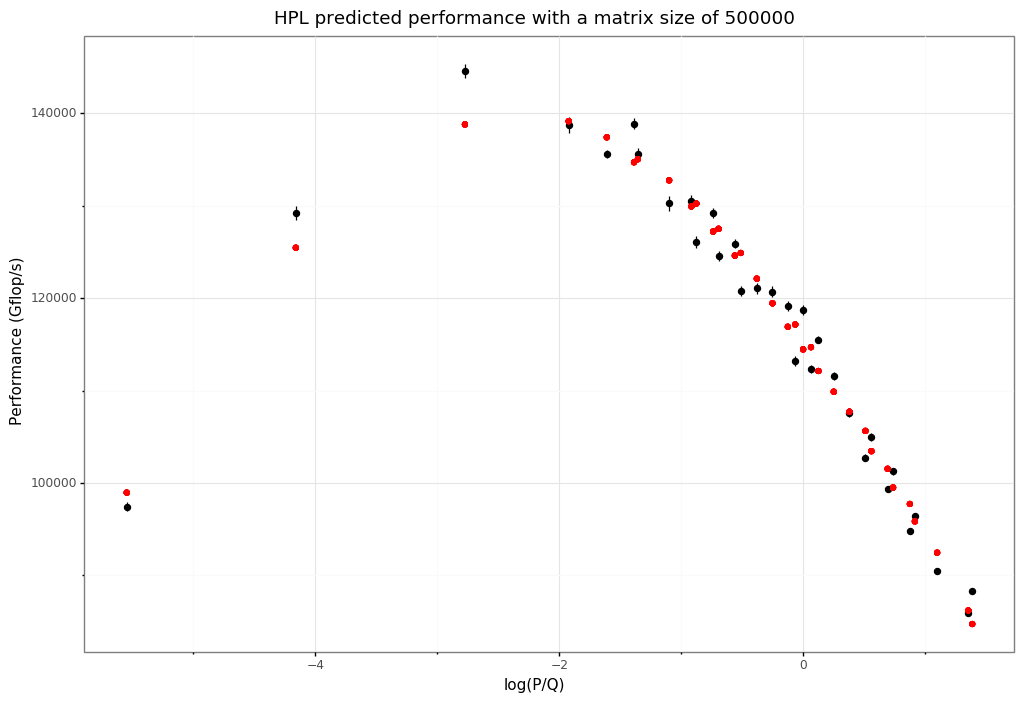

<ggplot: (-9223363284252895607)>

In [167]:
ggplot(tmp) +\
    aes(x='squareness', y='gflops', group='geometry') +\
    theme_bw() +\
    stat_summary(fun_ymin=lambda l: mean(l)-std(l), fun_ymax=lambda l: mean(l)+std(l), fun_y=mean) +\
    geom_point(aes(y='pred_gflops'), color='red') +\
    xlab('log(P/Q)') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='Number of removed nodes') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}')

In [170]:
l = []
for p in range(1, 17): #range(1, 500, 5):
    for q in range(1, 17): #range(1, 500, 5):
        l.append((p, q))

gen = pandas.DataFrame(l, columns=['proc_p', 'proc_q'])
gen['n'] = df.matrix_size.max()
gen['n2'] = gen['n'] ** 2
gen['n3'] = gen['n'] ** 3
gen['log_p'] = log(gen['proc_p'])
gen['log_q'] = log(gen['proc_q'])
gen['squareness'] = log(gen['proc_p'] * gen['proc_q'])
gen['nb_nodes'] = gen['proc_p'] * gen['proc_q']
p = reg.params
gen['pred'] = p.Intercept
for col, val in p.items():
    if col == 'Intercept':
        continue
    print(col)
    gen['pred'] += val * gen[col]
gen['pred_gflops'] = (2/3*gen['n3'] + 2*gen['n2']) / gen['pred'] * 1e-9
gen

proc_p
proc_q


,proc_p,proc_q,n,n2,n3,log_p,log_q,squareness,nb_nodes,pred,pred_gflops
0,1,1,500000,250000000000,125000000000000000,0.000000,0.000000,0.000000,1,454.362485,183408.261275
1,1,2,500000,250000000000,125000000000000000,0.000000,0.693147,0.693147,2,455.882998,182796.536974
2,1,3,500000,250000000000,125000000000000000,0.000000,1.098612,1.098612,3,457.403512,182188.879694
3,1,4,500000,250000000000,125000000000000000,0.000000,1.386294,1.386294,4,458.924025,181585.249011
4,1,5,500000,250000000000,125000000000000000,0.000000,1.609438,1.609438,5,460.444538,180985.605034
...,...,...,...,...,...,...,...,...,...,...,...
251,16,12,500000,250000000000,125000000000000000,2.772589,2.484907,5.257495,192,721.913742,115434.612834
252,16,13,500000,250000000000,125000000000000000,2.772589,2.564949,5.337538,208,723.434256,115191.992488
253,16,14,500000,250000000000,125000000000000000,2.772589,2.639057,5.411646,224,724.954769,114950.389882
254,16,15,500000,250000000000,125000000000000000,2.772589,2.708050,5.480639,240,726.475282,114709.798624


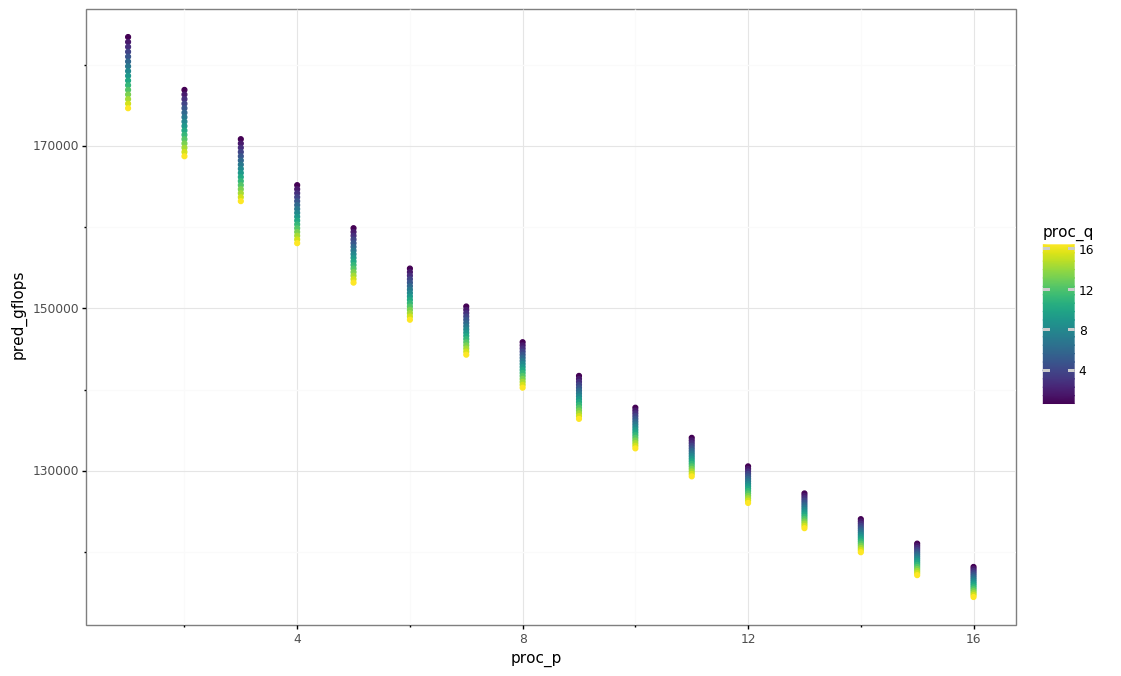

<ggplot: (-9223363284246568893)>


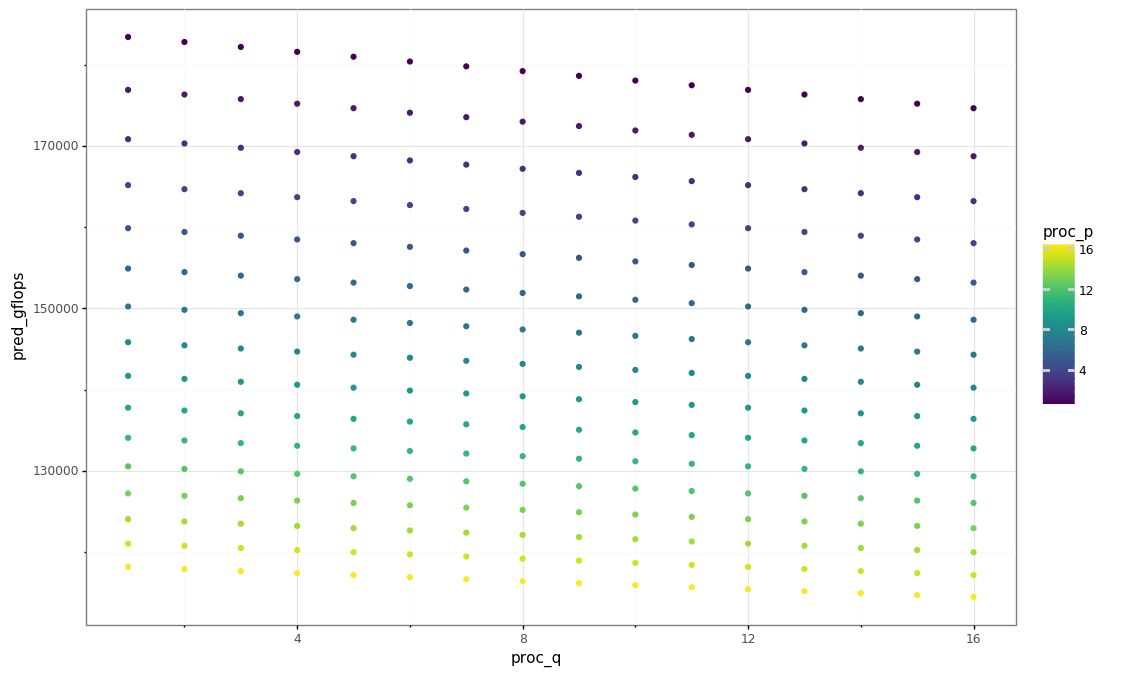

<ggplot: (8752607485437)>


In [171]:
plot = ggplot(gen[(gen.pred_gflops >= 0) & (gen.pred_gflops < df.gflops.max()*4)]) +\
    aes(y='pred_gflops') +\
    geom_point() +\
    theme_bw()

print(plot + aes(x='proc_p', color='proc_q'))
print(plot + aes(x='proc_q', color='proc_p'))

In [172]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [173]:
%%R
library(ggplot2)
library(dplyr)
R.version.string

[1] "R version 3.5.2 (2018-12-20)"


In [174]:
R_df = gen[['proc_p', 'proc_q', 'pred_gflops']]

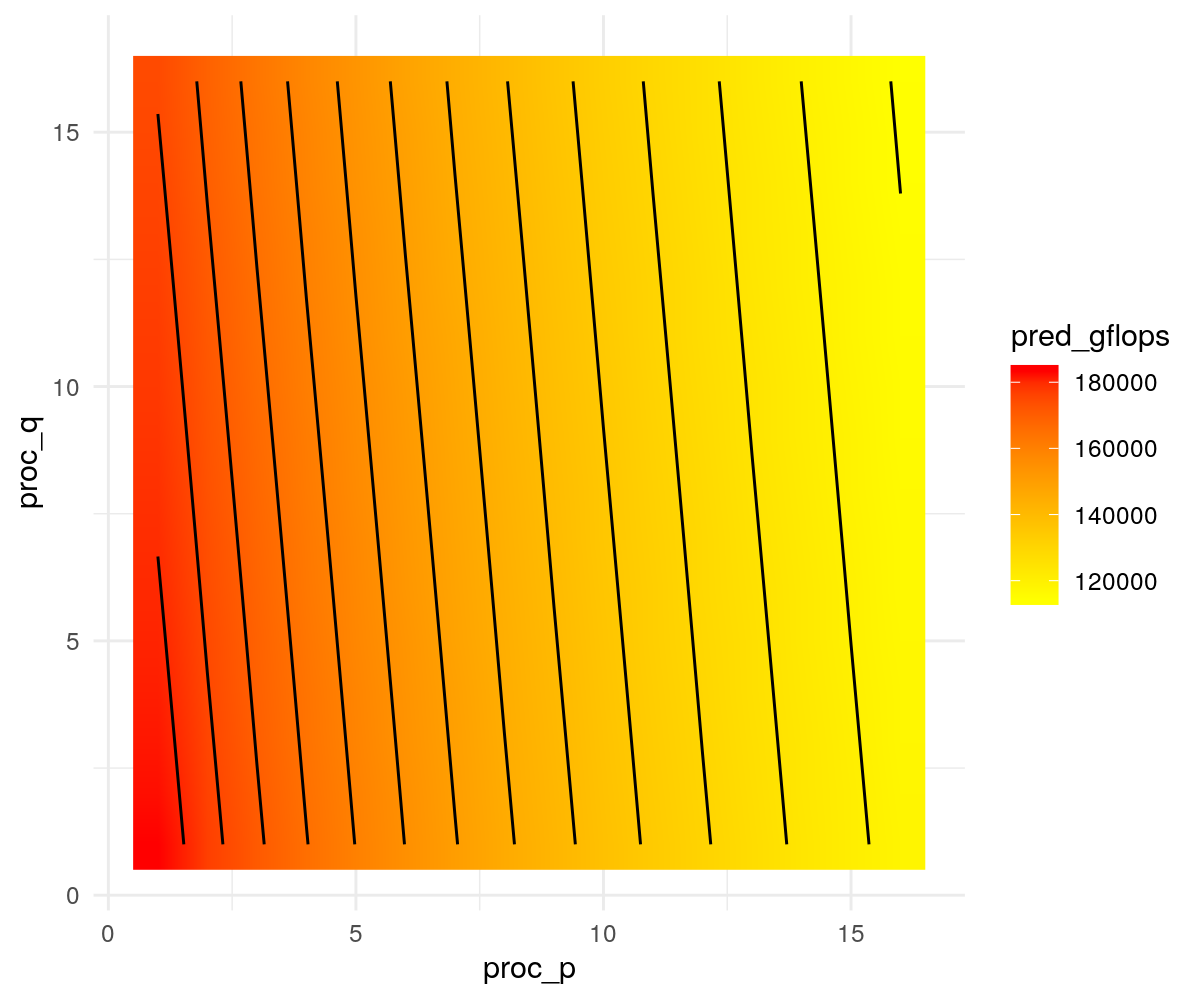

In [175]:
%%R -i R_df -w 6 -h 5 --units in -r 200
ggplot() +
    aes(x=proc_p, y=proc_q, fill=pred_gflops) +
    geom_raster(data=R_df %>% filter(pred_gflops >= 0, pred_gflops < 500000), interpolate=T) +
    scale_fill_gradient(low = 'yellow', high = 'red') +
    stat_contour(data=R_df %>% filter(pred_gflops >= 0, pred_gflops < 500000), aes(z=pred_gflops), color='black') +
    theme_minimal()

## Comparison with the *fast* nodes removed

In [22]:
alt_simulation_dir = 'synthetic_model/4/'
alt_simulation_files = [os.path.join(alt_simulation_dir, f) for f in os.listdir(alt_simulation_dir) if f.endswith('.zip')]

alt_df = pandas.concat([read_sim_result(f) for f in alt_simulation_files])
alt_df['nb_nodes'] = alt_df['proc_p'] * alt_df['proc_q']
alt_df['geometry'] = alt_df['proc_p'].astype(str) + '×' + alt_df['proc_q'].astype(str)
alt_df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,minor_page_fault,cpu_utilization,platform,filename,synthetic,nb_removed_nodes,theoretical_peak,theoretical_smart_peak,nb_nodes,geometry
0,300000,512,10,24,1,2,2,1,0,8,...,313152340,0.99,dahu_synthetic.xml,synthetic_model/4/nancy_2020-04-06_2350395.zip,True,16,197651.687078,185393.40945,240,10×24
1,500000,512,10,24,1,2,2,1,0,8,...,1046714916,0.99,dahu_synthetic.xml,synthetic_model/4/nancy_2020-04-06_2350395.zip,True,16,197651.687078,185393.40945,240,10×24
2,100000,512,10,24,1,2,2,1,0,8,...,20479066,1.00,dahu_synthetic.xml,synthetic_model/4/nancy_2020-04-06_2350395.zip,True,16,197651.687078,185393.40945,240,10×24
3,200000,512,10,24,1,2,2,1,0,8,...,90372776,1.00,dahu_synthetic.xml,synthetic_model/4/nancy_2020-04-06_2350395.zip,True,16,197651.687078,185393.40945,240,10×24
4,400000,512,10,24,1,2,2,1,0,8,...,632596182,0.99,dahu_synthetic.xml,synthetic_model/4/nancy_2020-04-06_2350395.zip,True,16,197651.687078,185393.40945,240,10×24


In [23]:
common_geom = set(alt_df.geometry.unique()) & set(df.geometry.unique())
print(common_geom)
a = df[df.geometry.isin(common_geom)].copy()
a['mode'] = 'fast'
b = df[df.geometry.isin(common_geom)].copy()
b['mode'] = 'slow'
comp_df = pandas.concat([a, b])
comp_df['id'] = comp_df['geometry'] + ':' + comp_df['mode']
comp_df.head()

{'15×16', '12×20', '10×24'}


,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,nb_nodes,geometry,squareness,n3,n2,n,log_p,log_q,mode,id
0,300000,512,12,20,1,2,2,1,0,8,...,240,12×20,-0.510826,27000000000000000,90000000000,300000,2.484907,2.995732,fast,12×20:fast
1,500000,512,12,20,1,2,2,1,0,8,...,240,12×20,-0.510826,125000000000000000,250000000000,500000,2.484907,2.995732,fast,12×20:fast
2,100000,512,12,20,1,2,2,1,0,8,...,240,12×20,-0.510826,1000000000000000,10000000000,100000,2.484907,2.995732,fast,12×20:fast
3,200000,512,12,20,1,2,2,1,0,8,...,240,12×20,-0.510826,8000000000000000,40000000000,200000,2.484907,2.995732,fast,12×20:fast
4,400000,512,12,20,1,2,2,1,0,8,...,240,12×20,-0.510826,64000000000000000,160000000000,400000,2.484907,2.995732,fast,12×20:fast


In [178]:
tmp = comp_df[(comp_df.matrix_size == comp_df.matrix_size.max()) & (comp_df.geometry.str.startswith('15'))]
a = set(tmp[tmp['mode'] == 'fast']['gflops'])
b = set(tmp[tmp['mode'] == 'slow']['gflops'])
a ^ b

set()